In [2]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
IMAGE_ROOT = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-06-lv3/data/fold_test/images"
#LABEL_ROOT = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-06-lv3/data/fold_0/annos"

In [4]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

In [5]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}


In [6]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [7]:
print("Sample PNG paths:", list(pngs)[:5])

Sample PNG paths: ['ID147_image1662342504123.png', 'ID251_image1663723177889.png', 'ID190_image1663032378555.png', 'ID180_image1662515885578.png', 'ID192_image1663032815373.png']


In [8]:
len(pngs)

288

In [9]:
pngs = sorted(pngs)

In [10]:
df_input = pd.read_csv('./output_9750.csv')

In [11]:
pngs[0].split('_')[1]

'image1661319116107.png'

In [12]:
image_dict = {name.split("_")[1]:name for name in list(pngs)}


In [13]:
df_input["image_path"] = df_input['image_name'].apply(lambda x: image_dict[x])

In [14]:
def rle_to_mask(rle, height, width):
    mask = np.zeros(height * width, dtype=np.uint8)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2] - 1
    lengths = array[1::2]
    for start, length in zip(starts, lengths):
        mask[start:start + length] = 1
    return mask.reshape((height, width))

In [15]:
class XRayDataset(Dataset):
    def __init__(self, df, is_train=True, transforms=None):
        
        
        self.df = df
        _filenames = self.df['image_name'].unique()

        self.filenames = _filenames
        self.is_train = is_train
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        # image_name = self.filenames[item]
        # image_path = os.path.join(IMAGE_ROOT, image_name)

        df_ = self.df[self.df['image_name']==self.filenames[item]]

        image_path = df_['image_path'].iloc[0]

        # image = cv2.imread(image_path)
        image = cv2.imread(os.path.join(IMAGE_ROOT, image_path))
        # image = image / 255.

        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)

        for index, row in df_.iterrows():
            rle = row['rle']
            class_ind = CLASS2IND[row['class']]
            mask = rle_to_mask(rle, 2048, 2048)
            label[..., class_ind] = mask

                
            
        return image, label, image_path

In [16]:
train_dataset = XRayDataset(df_input,is_train=True, transforms=None)

In [17]:
train_dataset[0][2]

'ID040_image1661319116107.png'

In [18]:
SAVE_ROOT = './crop_test_Trapezoid'

In [19]:
from tqdm import tqdm 

In [20]:
CLASS2IND['Trapezoid']

20

In [21]:
fold_dir = os.path.join(SAVE_ROOT)
os.makedirs(fold_dir, exist_ok=True)

image_dir = os.path.join(fold_dir, 'images')
os.makedirs(image_dir, exist_ok=True)

# annos_dir = os.path.join(fold_dir, 'annos')
# os.makedirs(annos_dir, exist_ok=True)

crop_size = (224, 224)  # (height, width)

for i in tqdm(range(len(train_dataset))):
    image, label, image_path = train_dataset[i]

    # for k in [CLASS2IND['Trapezoid']]: # ,CLASS2IND['Pisiform']
    # for k in [CLASS2IND['Pisiform']]:
    for k in [CLASS2IND['Trapezoid']]:

        coords = np.column_stack(np.where(label[:,:,k] > 0))

        x_min, y_min = coords.min(axis=0)  
        x_max, y_max = coords.max(axis=0)  


        if abs(x_max - x_min) > crop_size[0] or abs(y_max - y_min) > crop_size[1]:
            print(abs(x_max - x_min))
            print(abs(y_max - y_min))
            print('????')


        center_x = (x_min + x_max) // 2
        center_y = (y_min + y_max) // 2

        half_h = crop_size[0] // 2
        half_w = crop_size[1] // 2

        # cropped_image = image[x_min-10:x_max+10,y_min-10:y_max+10]
        # cropped_mask = label[x_min-10:x_max+10,y_min-10:y_max+10,k]

        start_x = max(center_x - half_h, 0)
        start_y = max(center_y - half_w, 0)
        end_x = start_x + crop_size[0]
        end_y = start_y + crop_size[1]

        if end_x > image.shape[0]:
            start_x = image.shape[0] - crop_size[0]
            end_x = image.shape[0]

        if end_y > image.shape[1]:
            start_y = image.shape[1] - crop_size[1]
            end_y = image.shape[1]

        cropped_image = image[start_x:end_x, start_y:end_y]
        # cropped_mask = label[start_x:end_x, start_y:end_y, k]

        output_image_path = os.path.join(image_dir,str(k)+'_'+image_path)

    # break 
        cv2.imwrite(output_image_path, cropped_image)

        # t = str(k)+'_'+label_path.split('/')[-1]
        # t = t[:-4] + "png"
        # output_label_path = os.path.join(annos_dir,t)

        # cv2.imwrite(output_label_path, cropped_mask)


100%|██████████| 288/288 [03:33<00:00,  1.35it/s]


# AFTER PRED

In [21]:
crop_size = (224, 224)

In [23]:
image, label, image_path = train_dataset[0]

In [24]:
image_path

'ID040_image1661319116107.png'

In [26]:
str(CLASS2IND['Trapezoid']) + '_' + image_path

'20_ID040_image1661319116107.png'

In [31]:
PRED_PATH = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-06-lv3/mmsegmentation/work_dirs/seg_b5_crop"

In [43]:
def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [45]:
image_path.split('_')[1]

'image1661319116107.png'

In [46]:
filenames = [] 
rles = []
for i in tqdm(range(len(train_dataset))):
    image, label, image_path = train_dataset[i]

    # for k in [CLASS2IND['Trapezoid']]: # ,CLASS2IND['Pisiform']
    # for k in [CLASS2IND['Pisiform']]:
    for k in [CLASS2IND['Trapezoid']]:

        coords = np.column_stack(np.where(label[:,:,k] > 0))

        x_min, y_min = coords.min(axis=0)  
        x_max, y_max = coords.max(axis=0)  


        if abs(x_max - x_min) > crop_size[0] or abs(y_max - y_min) > crop_size[1]:
            print(abs(x_max - x_min))
            print(abs(y_max - y_min))
            print('????')


        center_x = (x_min + x_max) // 2
        center_y = (y_min + y_max) // 2

        half_h = crop_size[0] // 2
        half_w = crop_size[1] // 2

        # cropped_image = image[x_min-10:x_max+10,y_min-10:y_max+10]
        # cropped_mask = label[x_min-10:x_max+10,y_min-10:y_max+10,k]

        start_x = max(center_x - half_h, 0)
        start_y = max(center_y - half_w, 0)
        end_x = start_x + crop_size[0]
        end_y = start_y + crop_size[1]

        if end_x > image.shape[0]:
            start_x = image.shape[0] - crop_size[0]
            end_x = image.shape[0]

        if end_y > image.shape[1]:
            start_y = image.shape[1] - crop_size[1]
            end_y = image.shape[1]

        # cropped_image = image[start_x:end_x, start_y:end_y]
        # cropped_mask = label[start_x:end_x, start_y:end_y, k]

        label_shape = (2048,2048)
        label = np.zeros(label_shape, dtype=np.uint8)
        pred_image_path = os.path.join(PRED_PATH,str(k) + '_' + image_path)

        pred_label = cv2.imread(pred_image_path)[...,0]

        label[start_x:end_x, start_y:end_y] = pred_label

        rle = encode_mask_to_rle(label)
        rles.append(rle)
        filenames.append(image_path.split('_')[1])

        # output_image_path = os.path.join(image_dir,str(k)+'_'+image_path)

    # break 
        # cv2.imwrite(output_image_path, cropped_image)


100%|██████████| 288/288 [03:41<00:00,  1.30it/s]


In [47]:
rles[0]

'3003223 5 3005265 13 3007310 20 3009355 27 3011401 31 3013448 35 3015494 40 3017540 45 3019587 48 3021633 54 3023680 58 3025726 62 3027771 67 3029817 70 3031864 72 3033911 74 3035958 77 3038005 79 3040052 81 3042099 83 3044147 84 3046194 86 3048242 88 3050290 89 3052337 90 3054385 91 3056433 91 3058481 92 3060528 93 3062576 93 3064624 93 3066672 94 3068720 94 3070768 94 3072817 93 3074865 94 3076913 94 3078962 93 3081010 94 3083059 93 3085107 93 3087155 94 3089203 94 3091252 93 3093300 93 3095349 93 3097397 93 3099446 92 3101494 92 3103542 92 3105591 91 3107640 90 3109688 89 3111736 89 3113784 88 3115832 88 3117880 87 3119928 87 3121976 86 3124024 86 3126072 86 3128121 84 3130169 84 3132217 83 3134265 82 3136313 81 3138362 79 3140410 76 3142458 74 3144506 74 3146555 72 3148603 70 3150652 61 3152701 59 3154749 58 3156798 55 3158847 51 3160896 48 3162945 45 3164993 43 3167043 38 3169092 37 3171141 34 3173191 29 3175240 26 3177289 24 3179340 20 3181390 16 3183440 12 3185491 8 3187542 1'

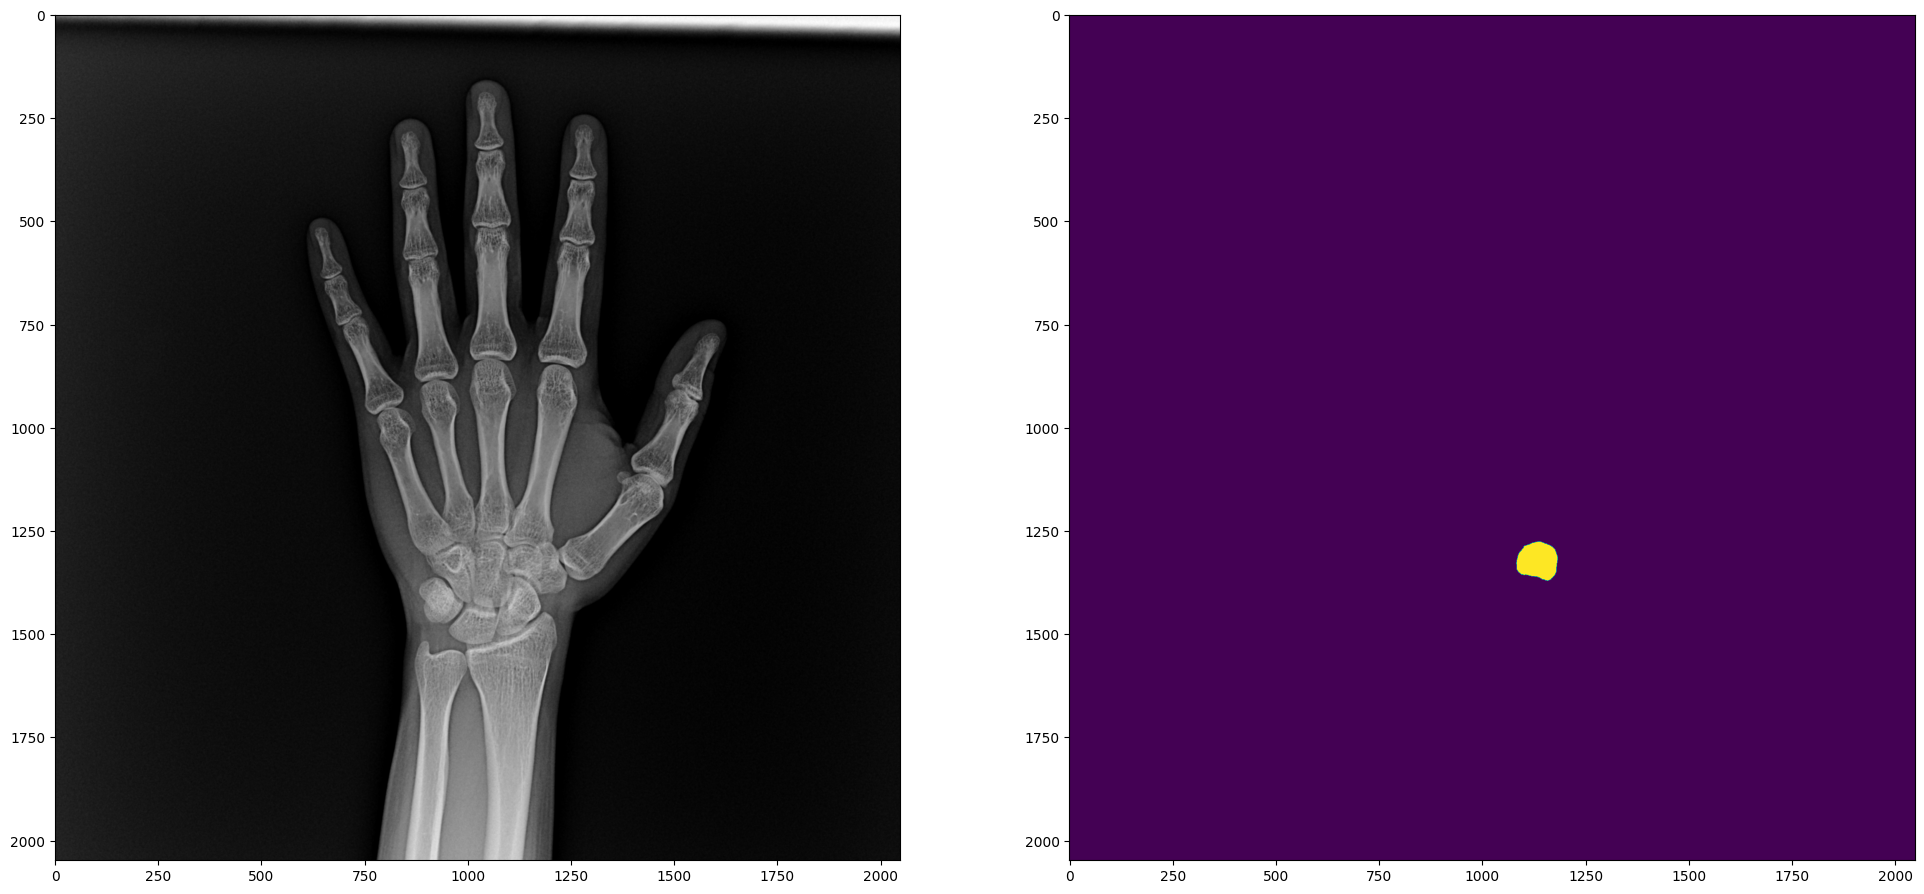

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image) 
ax[1].imshow(label)


In [51]:
['Trapezoid']*len(filenames)

['Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trapezoid',
 'Trap

In [ ]:
filenames

In [ ]:
df = pd.DataFrame({
    "image_name": filenames,
    "class": ['Trapezoid']*len(filenames),
    "rle": rles,
})

In [54]:
df_input

,image_name,class,rle,image_path
0,image1661319116107.png,finger-1,1814991 12 1817037 18 1819084 22 1821131 25 18...,ID040_image1661319116107.png
1,image1661319116107.png,finger-2,2077244 1 2077246 5 2079281 19 2081328 22 2083...,ID040_image1661319116107.png
2,image1661319116107.png,finger-3,2534044 1 2536090 10 2538136 12 2540181 16 254...,ID040_image1661319116107.png
3,image1661319116107.png,finger-4,826066 13 828112 17 830158 21 832205 24 834252...,ID040_image1661319116107.png
4,image1661319116107.png,finger-5,1082113 2 1084156 10 1086200 15 1088244 19 109...,ID040_image1661319116107.png
...,...,...,...,...
8347,image1667354424553.png,Lunate,2882561 14 2884606 20 2886651 26 2888697 33 28...,ID550_image1667354424553.png
8348,image1667354424553.png,Triquetrum,2794386 14 2796429 22 2798475 28 2800521 32 28...,ID550_image1667354424553.png
8349,image1667354424553.png,Pisiform,2839458 12 2841504 20 2843551 24 2845597 29 28...,ID550_image1667354424553.png
8350,image1667354424553.png,Radius,2964639 8 2966685 11 2968732 13 2970779 16 297...,ID550_image1667354424553.png


In [53]:
df

,image_name,class,rle
0,image1661319116107.png,Trapezoid,3003223 5 3005265 13 3007310 20 3009355 27 301...
1,image1661319145363.png,Trapezoid,2856033 11 2858075 20 2858097 2 2860121 28 286...
2,image1661319356239.png,Trapezoid,2782073 14 2784119 22 2786164 27 2788211 31 27...
3,image1661319390106.png,Trapezoid,2739227 3 2741270 12 2743312 19 2745355 26 274...
4,image1661320372752.png,Trapezoid,2777996 11 2780039 25 2782084 34 2784130 43 27...
...,...,...,...
283,image1664154624841.png,Trapezoid,2374722 13 2376768 18 2378814 25 2380860 29 23...
284,image1667354218823.png,Trapezoid,2808741 5 2810787 11 2812832 17 2814877 24 281...
285,image1667354234602.png,Trapezoid,2776177 9 2778224 12 2780268 17 2782312 24 278...
286,image1667354405140.png,Trapezoid,2710376 5 2712423 6 2714470 8 2716518 9 271856...


In [55]:
merged_df = df_input.merge(df, on=['image_name', 'class'], how='left', suffixes=('_df1', '_df2'))


In [58]:
merged_df['rle'] = merged_df['rle_df2'].combine_first(merged_df['rle_df1'])

In [59]:
final_df = merged_df[['image_name', 'class', 'rle']]


In [61]:
final_df.to_csv("./output_9750_crop_Trapezoid.csv", index=False)

In [ ]:
df.988